<a href="https://colab.research.google.com/github/ro-witthawin/BU-DeepReinforcementLearning/blob/workshop2/BU_DeepRL_Workshop_Day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!git clone -b workshop2 https://github.com/ro-witthawin/BU-DeepReinforcementLearning.git
!cp -R BU-DeepReinforcementLearning/BU_DeepRL_Workshop_Day2 FlappyBird

Cloning into 'BU-DeepReinforcementLearning'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 97 (delta 30), reused 69 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (97/97), 7.70 MiB | 22.33 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [10]:
ls FlappyBird

agent.py  experience_replay.py  README.md         runs/
dqn.py    hyperparameters.yml   requirements.txt  video/


In [ ]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+5build2).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.13).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!pip install -r FlappyBird/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
cd FlappyBird

/content/FlappyBird


In [15]:
def rewrite_file(filename: str, new_content: str):
    """
    Rewrites the given file with new content.

    :param filename: str - The name of the file to rewrite.
    :param new_content: str - The new content to write into the file.
    """
    try:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(new_content)
        print(f"Successfully rewritten {filename}")
    except Exception as e:
        print(f"Error rewriting {filename}: {e}")

agent_for_colab = """
import gymnasium as gym
import numpy as np
import cv2

import matplotlib
import matplotlib.pyplot as plt

import random
import torch
from torch import nn
import yaml

from experience_replay import ReplayMemory
from dqn import DQN

from datetime import datetime, timedelta
import argparse
import itertools

import flappy_bird_gymnasium
import os

# For printing date and time
DATE_FORMAT = "%m-%d %H:%M:%S"

# Directory for saving run info
RUNS_DIR = "runs"
os.makedirs(RUNS_DIR, exist_ok=True)

# 'Agg': used to generate plots as images and save them to a file instead of rendering to screen
matplotlib.use('Agg')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu' # force cpu, sometimes GPU not always faster than CPU due to overhead of moving data to GPU

def create_video(source, fps=60, output_name='output'):
    out = cv2.VideoWriter(output_name + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (source[0].shape[1], source[0].shape[0]))
    for i in range(len(source)):
        out.write(source[i])
    out.release()

# Deep Q-Learning Agent
class Agent():

    def __init__(self, hyperparameter_set):
        with open('hyperparameters.yml', 'r') as file:
            all_hyperparameter_sets = yaml.safe_load(file)
            hyperparameters = all_hyperparameter_sets[hyperparameter_set]
            # print(hyperparameters)

        self.hyperparameter_set = hyperparameter_set

        # Hyperparameters (adjustable)
        self.env_id             = hyperparameters['env_id']
        self.learning_rate_a    = hyperparameters['learning_rate_a']        # learning rate (alpha)
        self.discount_factor_g  = hyperparameters['discount_factor_g']      # discount rate (gamma)
        self.network_sync_rate  = hyperparameters['network_sync_rate']      # number of steps the agent takes before syncing the policy and target network
        self.replay_memory_size = hyperparameters['replay_memory_size']     # size of replay memory
        self.mini_batch_size    = hyperparameters['mini_batch_size']        # size of the training data set sampled from the replay memory
        self.epsilon_init       = hyperparameters['epsilon_init']           # 1 = 100% random actions
        self.epsilon_decay      = hyperparameters['epsilon_decay']          # epsilon decay rate
        self.epsilon_min        = hyperparameters['epsilon_min']            # minimum epsilon value
        self.stop_on_reward     = hyperparameters['stop_on_reward']         # stop training after reaching this number of rewards
        self.fc1_nodes          = hyperparameters['fc1_nodes']
        self.env_make_params    = hyperparameters.get('env_make_params',{}) # Get optional environment-specific parameters, default to empty dict
        self.enable_double_dqn  = hyperparameters['enable_double_dqn']      # double dqn on/off flag
        self.enable_dueling_dqn = hyperparameters['enable_dueling_dqn']     # dueling dqn on/off flag

        # Neural Network
        self.loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
        self.optimizer = None                # NN Optimizer. Initialize later.

        # Path to Run info
        self.LOG_FILE   = os.path.join(RUNS_DIR, f'{self.hyperparameter_set}.log')
        self.MODEL_FILE = os.path.join(RUNS_DIR, f'{self.hyperparameter_set}.pt')
        self.GRAPH_FILE = os.path.join(RUNS_DIR, f'{self.hyperparameter_set}.png')

    def run(self, is_training=True, render=False, save=False, save_episode=10000):
        if is_training:
            start_time = datetime.now()
            last_graph_update_time = start_time

            log_message = f"{start_time.strftime(DATE_FORMAT)}: Training starting..."
            print(log_message)
            with open(self.LOG_FILE, 'w') as file:
                file.write(log_message + "\\n")

        # Create instance of the environment.
        # Use "**self.env_make_params" to pass in environment-specific parameters from hyperparameters.yml.
        if not save:
            env = gym.make(self.env_id, render_mode='human' if render else None, **self.env_make_params)
        else:
            env = gym.make(self.env_id, render_mode='rgb_array' if render else None, **self.env_make_params)

        # Number of possible actions
        num_actions = env.action_space.n
        # Get observation space size
        num_states = env.observation_space.shape[0] # Expecting type: Box(low, high, (shape0,), float64)

        # List to keep track of rewards collected per episode.
        rewards_per_episode = []

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(num_states, num_actions, self.fc1_nodes, self.enable_dueling_dqn).to(device)

        if is_training:
            # Initialize epsilon
            epsilon = self.epsilon_init

            # Initialize replay memory
            memory = ReplayMemory(self.replay_memory_size)

            # Create the target network and make it identical to the policy network
            target_dqn = DQN(num_states, num_actions, self.fc1_nodes, self.enable_dueling_dqn).to(device)
            target_dqn.load_state_dict(policy_dqn.state_dict())

            # Policy network optimizer. "Adam" optimizer can be swapped to something else.
            self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

            # List to keep track of epsilon decay
            epsilon_history = []

            # Track number of steps taken. Used for syncing policy => target network.
            step_count=0

            # Track best reward
            best_reward = -9999999
        else:
            # Load learned policy
            # policy_dqn.load_state_dict(torch.load(self.MODEL_FILE), strict=False)
            policy_dqn.load_state_dict(torch.load(self.MODEL_FILE))

            # switch model to evaluation mode
            policy_dqn.eval()

        # Train INDEFINITELY, manually stop the run when you are satisfied (or unsatisfied) with the results
        for episode in itertools.count():
            # print(f"episode : {episode}")
            state, _ = env.reset()  # Initialize environment. Reset returns (state,info).
            state = torch.tensor(state, dtype=torch.float, device=device) # Convert state to tensor directly on device

            terminated = False      # True when agent reaches goal or fails
            episode_reward = 0.0    # Used to accumulate rewards per episode

            if save and (episode % save_episode == 0):
                frames = []

            # Perform actions until episode terminates or reaches max rewards
            # (on some envs, it is possible for the agent to train to a point where it NEVER terminates, so stop on reward is necessary)
            while(not terminated and episode_reward < self.stop_on_reward):

                # Select action based on epsilon-greedy
                if is_training and random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample()
                    action = torch.tensor(action, dtype=torch.int64, device=device)
                else:
                    # select best action
                    with torch.no_grad():
                        # state.unsqueeze(dim=0): Pytorch expects a batch layer, so add batch dimension i.e. tensor([1, 2, 3]) unsqueezes to tensor([[1, 2, 3]])
                        # policy_dqn returns tensor([[1], [2], [3]]), so squeeze it to tensor([1, 2, 3]).
                        # argmax finds the index of the largest element.
                        action = policy_dqn(state.unsqueeze(dim=0)).squeeze().argmax()

                # Execute action. Truncated and info is not used.
                new_state,reward,terminated,truncated,info = env.step(action.item())

                # Accumulate rewards
                episode_reward += reward

                # Convert new state and reward to tensors on device
                new_state = torch.tensor(new_state, dtype=torch.float, device=device)
                reward = torch.tensor(reward, dtype=torch.float, device=device)

                if is_training:
                    # Save experience into memory
                    memory.append((state, action, new_state, reward, terminated))

                    # Increment step counter
                    step_count+=1

                # Move to the next state
                state = new_state
                if save and (episode % save_episode == 0):
                    frames.append(env.render()[..., ::-1])
            # Keep track of the rewards collected per episode.
            rewards_per_episode.append(episode_reward)


            if save and (episode % save_episode == 0):
                str_episode = "{:08d}".format(episode)
                print(f"Save video/{str_episode}.mp4")
                create_video(frames, 30, f'video/{str_episode}')

            # Save model when new best reward is obtained.
            if is_training:
                if episode_reward > best_reward:
                    log_message = f"{datetime.now().strftime(DATE_FORMAT)}: New best reward {episode_reward:0.1f} ({(episode_reward-best_reward)/best_reward*100:+.1f}%) at episode {episode}, saving model..."
                    print(log_message)
                    with open(self.LOG_FILE, 'a') as file:
                        file.write(log_message + "\\n")

                    torch.save(policy_dqn.state_dict(), self.MODEL_FILE)
                    best_reward = episode_reward


                # Update graph every x seconds
                current_time = datetime.now()
                if current_time - last_graph_update_time > timedelta(seconds=10):
                    self.save_graph(rewards_per_episode, epsilon_history)
                    last_graph_update_time = current_time

                # If enough experience has been collected
                if len(memory)>self.mini_batch_size:
                    mini_batch = memory.sample(self.mini_batch_size)
                    self.optimize(mini_batch, policy_dqn, target_dqn)

                    # Decay epsilon
                    epsilon = max(epsilon * self.epsilon_decay, self.epsilon_min)
                    epsilon_history.append(epsilon)

                    # Copy policy network to target network after a certain number of steps
                    if step_count > self.network_sync_rate:
                        target_dqn.load_state_dict(policy_dqn.state_dict())
                        step_count=0


    def save_graph(self, rewards_per_episode, epsilon_history):
        # Save plots
        fig = plt.figure(figsize=(16, 9))

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        mean_rewards = np.zeros(len(rewards_per_episode))
        for x in range(len(mean_rewards)):
            mean_rewards[x] = np.mean(rewards_per_episode[max(0, x-99):(x+1)])
        plt.subplot(211) # plot on a 1 row x 2 col grid, at cell 1
        # plt.xlabel('Episodes')
        plt.ylabel('Mean Rewards')
        plt.plot(mean_rewards)

        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(212) # plot on a 1 row x 2 col grid, at cell 2
        # plt.xlabel('Time Steps')
        plt.ylabel('Epsilon Decay')
        plt.plot(epsilon_history)

        # plt.subplots_adjust(wspace=1.0, hspace=1.0)

        # Save plots
        fig.savefig(self.GRAPH_FILE)
        plt.close(fig)


    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        # Transpose the list of experiences and separate each element
        states, actions, new_states, rewards, terminations = zip(*mini_batch)

        # Stack tensors to create batch tensors
        # tensor([[1,2,3]])
        states = torch.stack(states)

        actions = torch.stack(actions)

        new_states = torch.stack(new_states)

        rewards = torch.stack(rewards)
        terminations = torch.tensor(terminations).float().to(device)

        with torch.no_grad():
            if self.enable_double_dqn:
                best_actions_from_policy = policy_dqn(new_states).argmax(dim=1)

                target_q = rewards + (1-terminations) * self.discount_factor_g * \
                                target_dqn(new_states).gather(dim=1, index=best_actions_from_policy.unsqueeze(dim=1)).squeeze()
            else:
                # Calculate target Q values (expected returns)
                target_q = rewards + (1-terminations) * self.discount_factor_g * target_dqn(new_states).max(dim=1)[0]
                '''
                    target_dqn(new_states)  ==> tensor([[1,2,3],[4,5,6]])
                        .max(dim=1)         ==> torch.return_types.max(values=tensor([3,6]), indices=tensor([3, 0, 0, 1]))
                            [0]             ==> tensor([3,6])
                '''

        # Calcuate Q values from current policy
        current_q = policy_dqn(states).gather(dim=1, index=actions.unsqueeze(dim=1)).squeeze()
        '''
            policy_dqn(states)  ==> tensor([[1,2,3],[4,5,6]])
                actions.unsqueeze(dim=1)
                .gather(1, actions.unsqueeze(dim=1))  ==>
                    .squeeze()                    ==>
        '''

        # Compute loss
        loss = self.loss_fn(current_q, target_q)

        # Optimize the model (backpropagation)
        self.optimizer.zero_grad()  # Clear gradients
        loss.backward()             # Compute gradients
        self.optimizer.step()       # Update network parameters i.e. weights and biases

if __name__ == '__main__':
    # Parse command line inputs
    parser = argparse.ArgumentParser(description='Train or test model.')
    parser.add_argument('hyperparameters', help='')
    parser.add_argument('--train', help='Training mode', action='store_true')
    args = parser.parse_args()

    dql = Agent(hyperparameter_set=args.hyperparameters)

    if args.train:
        dql.run(is_training=True)
    else:
        # dql.run(is_training=False, render=True)
        dql.run(is_training=False, render=True, save=True, save_episode=1000)
"""

rewrite_file("agent.py", agent_for_colab)

Successfully rewritten agent.py


In [17]:
!python agent.py flappybird2

/content/FlappyBird/agent.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_dqn.load_state_dict(torch.load(self.MODEL_FILE))
Save video/00000000.mp4
Save video/00

In [ ]:
!python agent.py flappybird2

(12,)
/content/FlappyBird/agent.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_dqn.load_state_dict(torch.load(self.MODEL_FILE))
Save video/00000000.mp4
Save vi

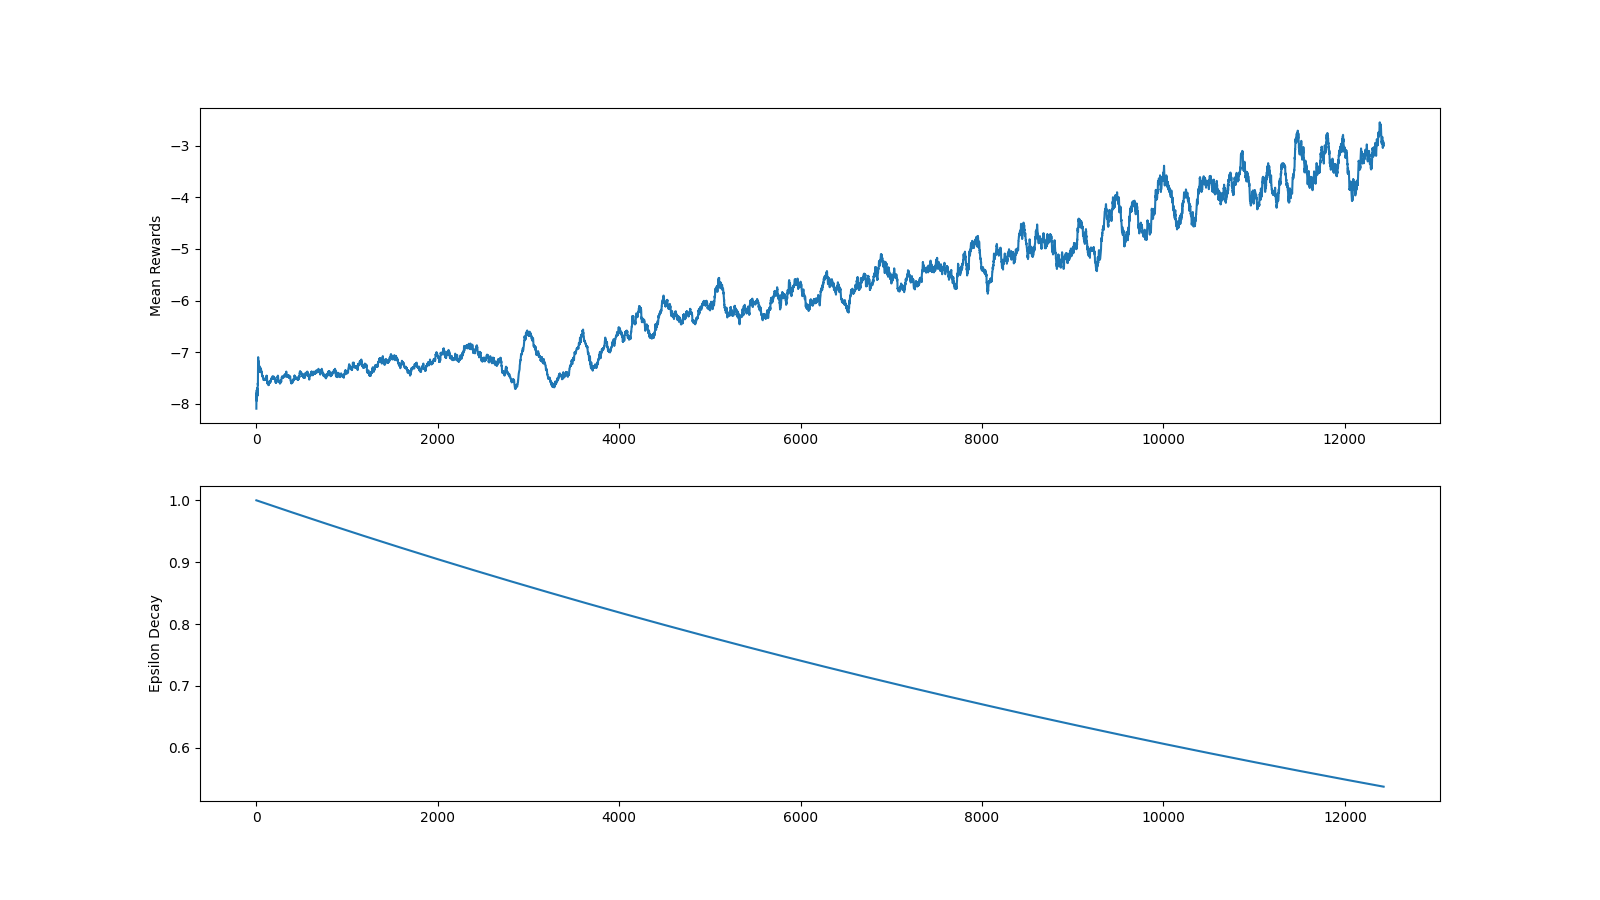

In [ ]:
from PIL import Image
import IPython.display as display

# Load the image
image_path = "runs/flappybird2.png"  # Replace with your file path
image = Image.open(image_path)

# Display the image
display.display(image)